In [1]:
###%matplotlib widget
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from pprint import pprint
from matplotlib.lines import Line2D
from glob import glob 
import sys

from scipy.special import comb
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

def get_gen_ind(txt):
    s = (txt.split('.')[-2]).split('_')[-2:]
    print(txt.split('.')[-2])
    print(txt, s)
    return int(s[0][3:]), int(s[1][3:])

def filter_spikes(spikes, start_t, end_t):
    f = []
    for i, times in enumerate(spikes):
        if len(times) == 0:
            f.append([])
            continue
        
        ts = np.array(times)
        whr = np.where(np.logical_and(start_t <= ts, ts < end_t))[0]
        
        if len(whr) == 0:
            f.append([])
            continue
        
        f.append(ts[whr].tolist())
    
    return f
            
def spikes_to_classes(spikes, sample_dt, sample_indices):
    classes = []
    for times in spikes:
        l = []
        for t in times:
            idx = int(t // sample_dt)
            ind_idx = sample_indices[ idx ] - 1
#             print(t, idx, ind_idx)
            l.append(ind_idx)
        classes.append(l)
    return classes
    

def spikes_to_vectors(spikes, start_t, end_t, sample_dt, labels, n_classes, n_out):
    d = {l: [] for l in range(n_classes)}
    counts = [0 for l in range(n_classes)]
    for sample, st in enumerate(np.arange(start_t, end_t + 1, sample_dt)):

        et = st + sample_dt
        idx = int(st // sample_dt)
        
        c = labels[ idx ] - 1
        counts[c] += 1
        
        v = np.zeros(n_out)
        for i, times in enumerate(spikes):
            if len(times) == 0:
                continue
            
            ts = np.asarray(times)
            whr = np.where(np.logical_and(st <= ts, ts < et))[0]

            if len(whr):
                v[i] = 1
        d[c].append(v)
        
    print(counts)

    return d

def accum_vectors(vecs):
    d = {k: np.zeros_like(vecs[k][0], dtype='uint')\
                                         for k in vecs}
    
    for k in vecs:
        for v in vecs[k]:
            d[k][:] = np.logical_or(d[k], np.asarray(v) > 0)
    return d

def accuracy(centroids, tests):
    accs = {}
    for cls, vs in tests.items():
        cols = {}
        for k, ctr in centroids.items():
            cols[k] = [int(np.sum(np.logical_and(ctr, v))) for v in vs]

        accs[cls] = cols

    return accs

def to_dict(npz):
    d = {}
    for k in npz.keys():
        try:
            d[k] = npz[k].item()
        except:
            d[k] = npz[k]
    return d

In [2]:
result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
for f in result_files:
    tmp = to_dict( np.load(f, allow_pickle=True) )
    if not tmp['died']:
        spks = tmp['recs']['output'][0]['spikes']
        for k in spks:
            if len(k):
                print(np.min(k), np.max(k))


1305.0 47152.0
4.0 3652.0
4.0 41703.0
204.0 20852.0
21459.0 62102.0
20006.0 45902.0
16209.0 43753.0
4006.0 26202.0
4.0 12451.0
24907.0 28454.0
4106.0 46903.0
1507.0 46954.0
4.0 29752.0
28809.0 47352.0
28810.0 54706.0
8104.0 20053.0
4.0 21303.0
4.0 2302.0
4.0 38953.0
204.0 26752.0
4006.0 26502.0
8104.0 20902.0
12805.0 63505.0
4.0 6954.0
4.0 34652.0
4.0 10902.0
8104.0 14152.0
4006.0 69353.0
8104.0 76657.0
1305.0 4802.0
4.0 39253.0
4.0 12252.0
8104.0 19652.0
4.0 8702.0
4.0 17001.0
8103.0 30152.0
4.0 21152.0
4.0 20554.0
1507.0 9354.0
26907.0 58608.0
4.0 13752.0
4.0 36753.0
4.0 9805.0
4.0 752.0
12805.0 28153.0
31209.0 70608.0
4.0 5352.0
4.0 9452.0
4.0 43852.0
4.0 12454.0
4.0 52802.0
16105.0 27561.0
12805.0 51554.0
4.0 16553.0
4.0 5302.0
4.0 18553.0
16209.0 35652.0
4107.0 65303.0
4006.0 5002.0
4.0 15105.0
4.0 15302.0
4.0 7900.0
21459.0 61054.0
4.0 5002.0
13605.0 54153.0
4006.0 23355.0
4.0 15603.0
30405.0 34006.0
4.0 16704.0
8104.0 12453.0
8104.0 12252.0
4006.0 23590.0
4.0 3955.0
4.0 38707.0


dict_keys(['n_zones', 'labels', 'shapes', 'spikes'])
[0.0]


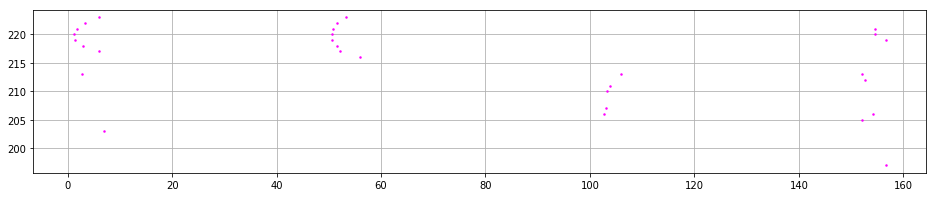

dict_keys(['n_zones', 'labels', 'shapes', 'spikes'])
[0.0]


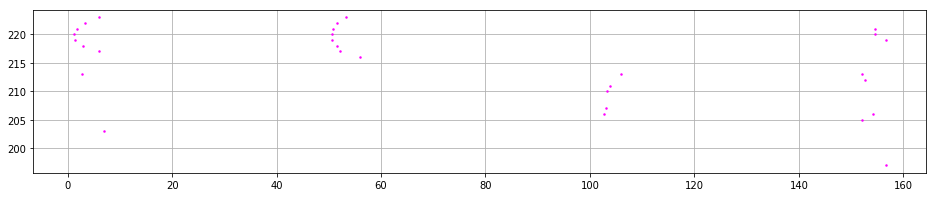

In [51]:
result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
c = ['red', 'green', 'blue', 'magenta']
for f in result_files[-10:]:
    tmp = to_dict( np.load(f, allow_pickle=True) )
    inputs = tmp['input']
    print(inputs.keys())
    spikes = inputs['spikes']
    print(sorted(spikes.keys()))
    
#     print(inputs['spikes'])
    for st in sorted(spikes.keys()):
        
        for layer in spikes[st]:
            if layer > 2:
                plt.figure(figsize=(16, 3))
                for nid, times in enumerate(spikes[st][layer]):
                    if nid < 190:
                        continue
                    ts = np.array(times)
                    ttt = ts[ts < 200.0]
            #         ttt = ts
                    plt.plot(ttt, np.ones_like(ttt) * nid, 
                             marker='.', markersize=5, color=c[layer], 
                             linestyle='none', markeredgewidth=0)
                plt.grid()
            plt.show()
#     for k in spks:
#         if len(k):
#             print(np.min(k), np.max(k))


/home/gp283/l2l-omniglot
./L2L-OMNIGLOT/run_results/data_gen00000_ind00000.npz
dict_keys(['params', 'recs', 'analysis', 'db_name', 'weights', 'died', 'input', 'fitness'])
dict_keys(['input', 'output'])
dict_keys([0, 1, 2, 3])
died = False
228 15.0996688705415 228
{0: [56, 56], 1: [56, 56], 2: [19, 12], 3: [19, 12]}


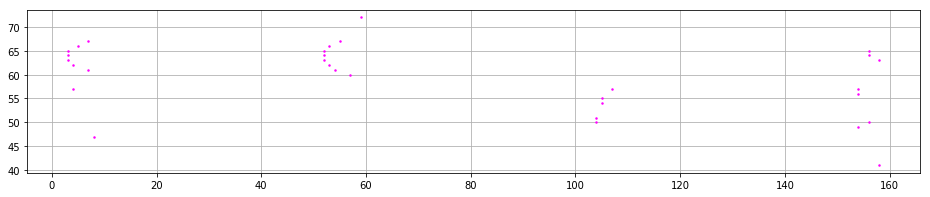

./L2L-OMNIGLOT/run_results/data_gen00000_ind00001.npz
dict_keys(['params', 'recs', 'analysis', 'db_name', 'weights', 'died', 'input', 'fitness'])
dict_keys(['input', 'output'])
dict_keys([0, 1, 2, 3])
died = False
228 15.0996688705415 228
{0: [56, 56], 1: [56, 56], 2: [19, 12], 3: [19, 12]}


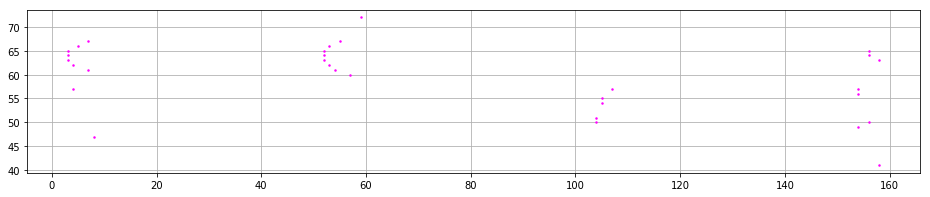

In [52]:
result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
print(os.getcwd())
c = ['red', 'green', 'blue', 'magenta']
for f in result_files[-10:]:
    print(f)
    tmp = to_dict( np.load(f, allow_pickle=True) )
    
    print(tmp.keys())
    print(tmp['recs'].keys())
    print(tmp['recs']['input'].keys())

    print('died = {}'.format(tmp['died']))
    
    spks = tmp['recs']['input'][3]['spikes']
    print(len(spks), np.sqrt(len(spks)), 19*12)
    print(tmp['input']['shapes'])
    
    plt.figure(figsize=(16, 3))
    for nid, times in enumerate(spks):
        if nid < 40 or nid > 75:
            continue
        ts = np.array(times)
        ttt = ts[ts < 200.0]
#         ttt = ts
        plt.plot(ttt, np.ones_like(ttt) * nid, 
                 marker='.', markersize=5, color=c[layer], 
                 linestyle='none', markeredgewidth=0)
    plt.grid()
    plt.show()
#     for k in spks:
#         if len(k):
#             print(np.min(k), np.max(k))


/home/gp283/l2l-omniglot
./L2L-OMNIGLOT/run_results/data_gen00000_ind00000.npz
dict_keys(['died', 'params', 'recs', 'db_name', 'weights', 'analysis', 'input', 'fitness'])
died = False


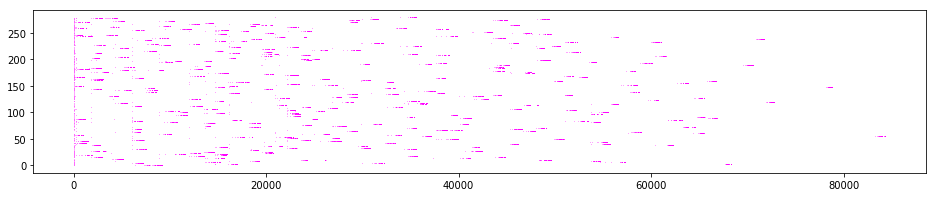

In [53]:
result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
print(os.getcwd())
c = ['red', 'green', 'blue', 'magenta']
for f in result_files[-10:]:
    print(f)
    tmp = to_dict( np.load(f, allow_pickle=True) )
    
    print(tmp.keys())
    print('died = {}'.format(tmp['died']))
    spks = tmp['recs']['output'][0]['spikes']
    plt.figure(figsize=(16, 3))
    for nid, times in enumerate(spks):
        plt.plot(times, np.ones_like(times) * nid, 
                 marker='.', markersize=1, color=c[layer], 
                 linestyle='none', markeredgewidth=0)

    plt.show()
#     for k in spks:
#         if len(k):
#             print(np.min(k), np.max(k))


In [2]:

result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# result_files = sorted(glob('/home/gp283/titan/run_results/*.npz'))
tmp = np.load(result_files[0], allow_pickle=True)

class_data = {}
train_vecs_single = {}
train_vecs_accum = {}
accuracies = {}
for rf in result_files[-1:]:
    
    try:
        tmp = np.load(rf, allow_pickle=True)
        data.clear()
        for k in tmp:
            try:
                data[k] = tmp[k].item()
            except:
                data[k] = tmp[k]
    except:
        continue
    
    
    gen, ind = get_gen_ind(rf)
    labels  = data['input']['labels']
    
    
    duration = data['params']['sim']['duration']
    n_test = data['params']['sim']['test_per_class']
    sample_dt = data['params']['sim']['sample_dt']
    n_samples = data['params']['sim']['samples_per_class']
    n_class = data['params']['sim']['num_classes']
    n_train = 1 * n_samples # epochs * samples
    n_out = data['params']['sim']['output_size']
    
    
    total_lbl = len(labels)
    end = total_lbl -  (n_class * n_test)
    start = end - (n_class * n_train)
    unique, counts = np.unique(labels[start : end], return_counts=True)
    print(dict(zip(unique, counts)))
#     print(labels[start : end])
    print(total_lbl, start, end)
    
    plt.close('all')
    fig = plt.figure(figsize=(15, 3))
    ax = plt.subplot(1, 4, 1)
    im = plt.hist(labels, bins=n_class)

    ax = plt.subplot(1, 4, 2)
    im = plt.hist(labels[start:], bins=n_class)
    
    ax = plt.subplot(1, 4, 3)
    im = plt.hist(labels[start:end], bins=n_class)
    
    ax = plt.subplot(1, 4, 4)
    im = plt.hist(labels[end:], bins=n_class)

    plt.show()
    
    end_t = duration - sample_dt * n_class * n_test
    start_t = end_t - sample_dt * n_class * n_train
    
#     print(start_t, end_t)
    spikes = filter_spikes(data['recs']['output'][0]['spikes'], start_t, end_t)
#     print(spikes)
#     classes = spikes_to_classes(spikes, sample_dt, labels)
    vecs = spikes_to_vectors(spikes, start_t, end_t, sample_dt, labels, n_class, n_out)
    # not every set has the same number so reduce
#     n_train = 50
    rand_class = np.tile(np.arange(n_class), n_train)
    train_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
    samp = train_id // n_class
    train_class = train_id % n_class
    train_vecs = [vecs[c][samp[i]].copy() for i, c in enumerate(train_class)]
    train_accums = accum_vectors(vecs)
    
    assert (n_class * n_train) == len(train_vecs), 'Not the same number of vectors'


    clf = KNeighborsClassifier()
#     clf = linear_model.LogisticRegression()
    clf.fit(train_vecs, train_class)
    
    v = data['analysis']['individual_per_class']['vectors']
#     print(v)
    if len(v):
        rand_class = np.tile(np.arange(n_class), n_test)
        test_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
        samp = test_id // n_class
        test_class = test_id % n_class
        test_vecs = [v[c][samp[i]].copy() for i, c in enumerate(test_class)]
        score = clf.score(test_vecs, test_class)

        scores = class_data.get(gen, [])
        scores.append(score)
        class_data[gen] = scores

        accuracies[gen] = accuracy(train_accums, v)


plt.figure()
for k in class_data:
    plt.plot(k, np.mean(class_data[k]), '.')
plt.show()

<Figure size 432x288 with 0 Axes>

In [3]:
# print(train_accums)
print(accuracies)


{}


In [4]:

# result_files = sorted(glob('./L2L-OMNIGLOT/run_results/*.npz'))
# result_files = sorted(glob('/home/gp283/titan/run_results/*.npz'))
tmp = np.load(result_files[0], allow_pickle=True)
data = {}
class_data = {}
for rf in result_files[-1:]:
    
    try:
        tmp = np.load(rf, allow_pickle=True)
        data.clear()
        for k in tmp:
            try:
                data[k] = tmp[k].item()
            except:
                data[k] = tmp[k]
    except:
        continue
    
    gen, ind = get_gen_ind(rf)
    
    n_class = data['params']['sim']['num_classes']
    n_test = data['params']['sim']['test_per_class']
    
    n_train = n_test - 1
    
    train_vecs = data['analysis']['aggregate_per_class']['vectors'].copy()
    train_class = np.arange(n_class, dtype='int')
    v = data['analysis']['individual_per_class']['vectors']
    
    if len(v) == 0:
        continue
    
#     rand_class = np.tile(np.arange(n_class), n_train)
#     train_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
#     samp = train_id // n_class
#     train_class = train_id % n_class
#     train_vecs = [v[c][samp[i]].copy() for i, c in enumerate(train_class)]
#     assert (n_class * n_train) == len(train_vecs), 'Not the same number of vectors'

#     test_class = np.arange(n_class, dtype='int')
#     test_vecs = [v[c][-1].copy() for c in test_class]
    
    rand_class = np.tile(np.arange(n_class), n_train)
    test_id = np.random.choice(len(rand_class), size=len(rand_class), replace=False)
    samp = test_id // n_class
    test_class = test_id % n_class
    test_vecs = [v[c][samp[i]].copy() for i, c in enumerate(test_class)]
    
    
    scores = class_data.get(gen, [])
    
#     clf = SVC(kernel="linear")#, C=0.025)
#     clf = SVC(gamma=2, C=1)
#     clf = KNeighborsClassifier()
#     clf = linear_model.LogisticRegression()
#     clf.fit(train_vecs, train_class)
    score = clf.score(test_vecs, test_class)
    
    scores.append(score)
    class_data[gen] = scores
    

/L2L-OMNIGLOT/run_results/data_gen00000_ind00004
./L2L-OMNIGLOT/run_results/data_gen00000_ind00004.npz ['gen00000', 'ind00004']


In [5]:
plt.figure()
for k in class_data:
    plt.plot(k, np.mean(class_data[k]), '.')
plt.show()

<Figure size 432x288 with 0 Axes>